## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [12]:
%load_ext autoreload
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/andrew_lee/sd-maskrcnn/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from autolab_core import YamlConfig


%matplotlib inline 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configurations

In [30]:
config_path = '/nfs/diskstation/andrew_lee/cfg/train_siamese_one_loss.yaml'
yaml_config = YamlConfig(config_path)

benchmark_config_path = '/nfs/diskstation/andrew_lee/cfg/benchmark_siamese.yaml'
benchmark_config = YamlConfig(benchmark_config_path)

yaml_config['dataset'], benchmark_config['model']

(OrderedDict([('path', '/nfs/diskstation/andrew_lee/wisdom_real_targets'),
              ('train_indices', 'target_test_indices.npy'),
              ('val_indices', None),
              ('images', 'color_ims'),
              ('masks', 'modal_segmasks'),
              ('targets', 'target_images'),
              ('augment', True)]),
 OrderedDict([('path',
               '/nfs/diskstation/andrew_lee/sdmaskrcnn_target_results/siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate20190317T1833/mask_rcnn_siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate_0020.h5'),
              ('backbone_path',
               '/nfs/diskstation/andrew_lee/sdmaskrcnn_target_results/siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate20190317T1833/mask_rcnn_resnet_siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate_0020.h5'),
              ('mode', 'inference'),
              ('settings',
               OrderedDict([('mean_pixel', [128, 128, 128]),
    

In [31]:
from sd_maskrcnn.config import MaskConfig
config = MaskConfig(yaml_config['model']['settings'])
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1

## Notebook Preferences

In [32]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:1"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [33]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [34]:
from sd_maskrcnn.dataset import TargetDataset

dataset_info = {
    'path': '/nfs/diskstation/andrew_lee/wisdom_real_targets',
    'indices': 'target_train_indices.npy',
    'images': 'color_ims',
    'masks': 'modal_segmasks',
    'targets': 'target_images',
}

test_dataset = TargetDataset(dataset_info['path'], images=dataset_info['images'],
                                 masks=dataset_info['masks'], targets=dataset_info['targets'])
test_dataset.load(imset=dataset_info['indices'])
test_dataset.prepare()


## Load Model

In [35]:
MODEL_DIR = '/nfs/diskstation/andrew_lee/sdmaskrcnn_target_results'

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
# if config.NAME == "shapes":
#     weights_path = SHAPES_MODEL_PATH
# elif config.NAME == "coco":
#     weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
model.load_weights_siamese(benchmark_config['model']['path'], benchmark_config['model']['backbone_path'])

Re-starting from epoch 20


## Run Detection

In [57]:
outputs = model.keras_model.get_layer('proposal_targets').output
names = ['rois', 'target_class_ids', 'target_bbox', 'target_mask', 'target_is_target']

desired = list(zip(names, outputs))
# desired += [('pred_target_prob', model.keras_model.get_layer('target_prob'))]

index = 45

base_inputs, extra_inputs = modellib.load_inputs_gt(test_dataset, config, index)

proposal_targets, inputs, _, pred_outputs = model.run_graph_train(base_inputs, extra_inputs, desired_outputs=desired)

Evaluating the following graph outputs in training mode:
 ['proposal_targets_4/rois:0', 'proposal_targets_4/target_class_ids:0', 'proposal_targets_4/target_bbox:0', 'proposal_targets_4/target_mask:0', 'proposal_targets_4/target_is_target:0']
Checkpoint Path: /nfs/diskstation/andrew_lee/sdmaskrcnn_target_results/siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate20190317T1833/mask_rcnn_siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate_{epoch:04d}.h5
rois                     shape: (1, 200, 4)           min:    0.00000  max:    1.00000  float32
target_class_ids         shape: (1, 200)              min:    0.00000  max:    1.00000  int32
target_bbox              shape: (1, 200, 4)           min:   -2.60820  max:    2.79782  float32
target_mask              shape: (1, 200, 28, 28)      min:    0.00000  max:    1.00000  float32
target_is_target         shape: (1, 200)              min:    0.00000  max:    1.00000  int32
Performing full prediction
1/1 [=======

rpn_class_logits (1, 65472, 2)
rpn_class (1, 65472, 2)
rpn_bbox (1, 65472, 4)
mrcnn_class_logits (1, 200, 2)
mrcnn_class (1, 200, 2)
mrcnn_bbox (1, 200, 2, 4)
mrcnn_mask (1, 200, 28, 28, 2)
rpn_rois (1, 2000, 4)
output_rois (1, 200, 4)
pred_target_prob (1, 200, 2)
rpn_class_loss (1,)
rpn_bbox_loss (1,)
class_loss,bbox_loss (1,)
mask_loss (1,)
target_loss (1,)
pred_outputs['pred_target_prob'].shape (1, 200, 2)
Example loss: 0.0741
[[187 156 250 185]
 [199 154 259 192]
 [171 230 282 416]
 [175 247 262 311]
 [174 251 274 380]
 [168 272 249 348]
 [181 153 255 193]
 [242 188 275 232]
 [176 272 267 363]
 [169 244 273 335]
 [162 169 250 238]
 [153 169 269 232]
 [163 170 225 231]
 [171 233 276 315]
 [161 258 278 349]
 [160 219 278 345]
 [146 213 258 357]
 [178 162 253 226]
 [160 236 283 370]
 [183 147 247 188]
 [158 232 259 334]
 [172 234 268 357]
 [170 178 251 226]
 [245 196 268 232]
 [242 193 270 235]
 [112   4 187  68]
 [205 222 256 248]
 [216 447 346 487]
 [434   0 451  10]
 [171 221 257 3

['0.44 0',
 '0.61 0',
 '0.46 0',
 '0.66 0',
 '0.72 0',
 '0.72 0',
 '0.50 0',
 '0.46 0',
 '0.67 0',
 '0.64 0',
 '0.65 1',
 '0.47 1',
 '0.33 1',
 '0.63 0',
 '0.53 0',
 '0.53 0',
 '0.58 0',
 '0.70 1',
 '0.56 0',
 '0.48 0',
 '0.49 0',
 '0.53 0',
 '0.53 1',
 '0.04 0',
 '0.41 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.10 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0',
 '0.00 0']

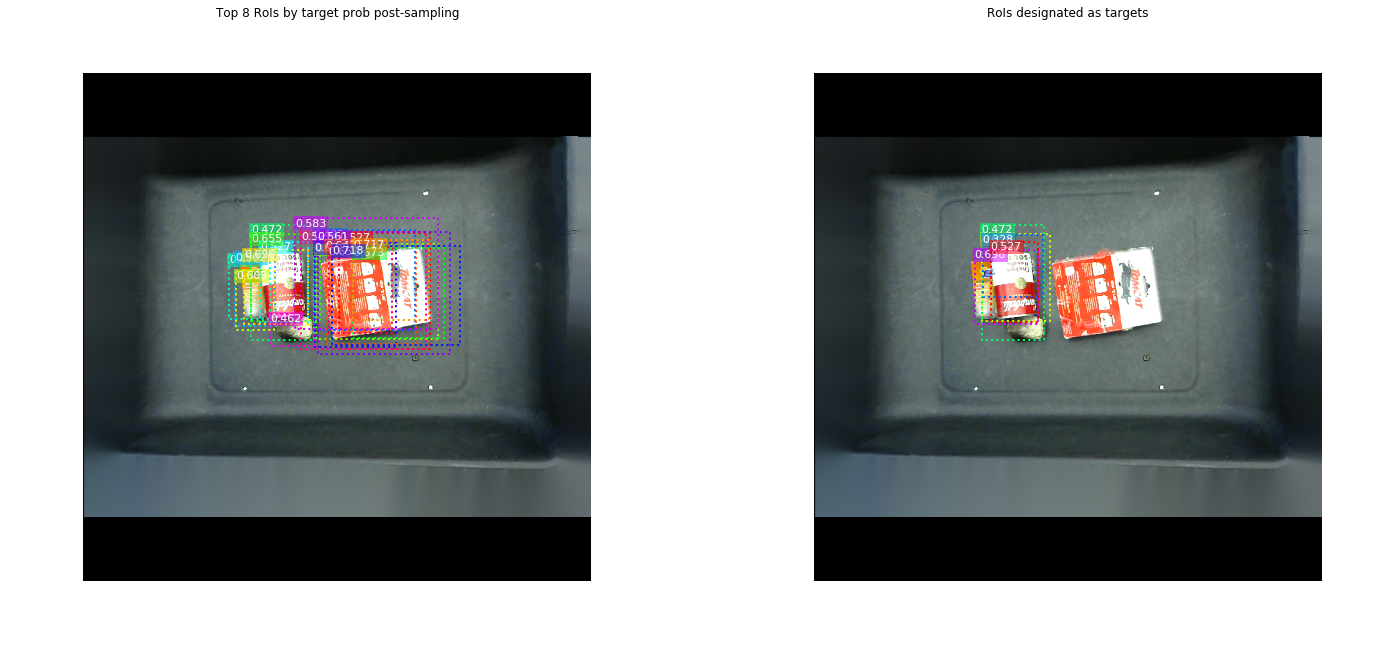

In [60]:
for k in pred_outputs.keys():
    print(k, pred_outputs[k].shape)


ax = get_ax(1, 2, size=12)

target_image = (np.squeeze(inputs[0]) + 128).astype(int)
pile_image = (np.squeeze(inputs[4]) + 128).astype(int)




post_sample_rois = utils.denorm_boxes(proposal_targets["rois"][0, :, :4], pile_image.shape[:2])

print("pred_outputs['pred_target_prob'].shape", pred_outputs['pred_target_prob'].shape)
pred_probs = np.squeeze(pred_outputs['pred_target_prob'])[:,1]

print('Example loss: {:.4f}'.format(pred_outputs['target_loss'][0]))

top_probs_indices = np.argsort(pred_probs)[::-1][:20]
visualize.draw_boxes(pile_image, boxes=post_sample_rois[top_probs_indices][::-1], ax=ax[0], 
                     captions=['{:.3f}'.format(p) for p in pred_probs[top_probs_indices]][::-1],
                     title='Top 8 RoIs by target prob post-sampling')

print(post_sample_rois[:40])


ax[1].imshow(pile_image)

target_is_target = np.squeeze(proposal_targets['target_is_target'])

target_gt_indices = np.squeeze(np.argwhere(target_is_target))
rois_positive_target = post_sample_rois[target_gt_indices,:]


_ = visualize.draw_boxes(pile_image, boxes=rois_positive_target, ax=ax[1], 
                     captions=['{:.3f}'.format(p) for p in pred_probs[target_gt_indices]],
                     title='RoIs designated as targets')

print('predicted vs gt, positive GT RoIs')
print(target_is_target[target_gt_indices])
print(pred_probs[target_gt_indices])

print('predicted vs gt, top 8 RoIs')
print(target_is_target[top_probs_indices])
print(pred_probs[top_probs_indices])

print('predicted vs gt, all RoIs')
['{:.2f} {}'.format(p, gt) for (p, gt) in list(zip(pred_probs, target_is_target))[:40]]

(1, 2000, 2) (1, 2000, 4)


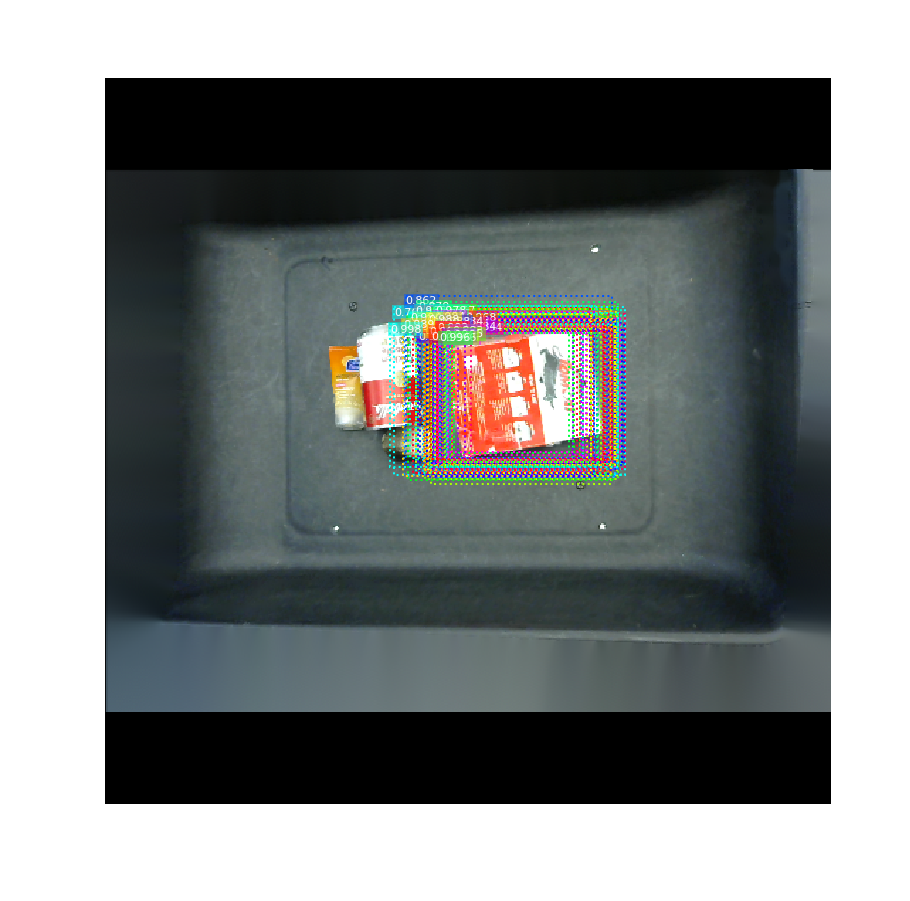

In [59]:
pred_info_path = '/nfs/diskstation/andrew_lee/sdmaskrcnn_target_results/siamese_pretrained_one_loss_wisdom_labelled_david_posweight_rotate20190317T1833/results_train_full/pred_info'

pred_output = np.load(os.path.join(pred_info_path, 'example_{:06d}.npy'.format(index))).item()

print(pred_output['target_probs_prefilter'].shape, pred_output['rois_prefilter'].shape)

rois = utils.denorm_boxes(np.squeeze(pred_output['rois_prefilter']), pile_image.shape[:2])
pred_probs = np.squeeze(pred_output['target_probs_prefilter'])[:,1]
top_probs_indices = np.argsort(pred_probs)[::-1][:80]

ax = get_ax(1)
visualize.draw_boxes(pile_image, boxes=rois[top_probs_indices][::-1], 
                     captions=['{:.3f}'.format(p) for p in pred_probs[top_probs_indices]][::-1],
                     ax=ax)




## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
image = pile_img
gt_class_id = pile_class_id
gt_bbox = bbox


# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
model.keras_model.get_layer("ROI").output

In [ ]:
model.metrics_tensors

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from
print(pillar)
print(model.keras_model.get_layer("ROI"))
# print([l.name for l in model.keras_model.layers])
pillar = pillar[0]

print('-------inputs-------')
def dfs(tensor, count=3, checked=None):
    checked = checked if checked is not None else []
    parents = tensor.op.inputs
    
    print(tensor.name, [p.name for p in parents])
    for p in parents:
        if p in checked:
            continue
        checked.append(p)
        if count > 0:
            dfs(p, count=count-1, checked=checked)
        
# dfs(pillar)

print('--------------------')

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")
    
# print(nms_node)

outputs = [
#     ("rpn_class", model.keras_model.get_layer("rpn_class").output),
#     ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
#     ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
#     ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
#     ("post_nms_anchor_ix", nms_node),
#     ("proposals", model.keras_model.get_layer("ROI").output[0]),
#     ("target_status", model.keras_model.get_layer("ROI").output[1]),
    
]

# print('-----outputs-----')
# for o in outputs:
#     print(o[1])
# print('-----------------')
rpn = model.run_graph([image], [target_img], [target_bb], outputs, image_metas=[pile_meta], 
                       target_metas=[target_meta])

In [ ]:

# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
print(rpn['pre_nms_anchors'])
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.

outputs = [
    ("proposals", model.keras_model.get_layer("ROI").output[0]),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
]

for o in outputs:
    print(o)

mrcnn = model.run_graph([image], [target_img], [target_bb], outputs, image_metas=[pile_meta], 
                       target_metas=[target_meta])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(test_dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(test_dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()